# PRISMA Plume Analysis with Background-Matched Uncertainty

This notebook mirrors the plume analysis walkthrough while incorporating the PRISMA spectral background-matching workflow from `uncertainty_analysis_prisma_spectral.ipynb` so background clutter contributes to the reported IME/flux uncertainties.


## 1. Setup and Imports

We add the PRISMA spectral helpers plus utilities for handling zipped Level-1 products so the methane-insensitive bands can be compared directly on the instrument sampling grid.


In [ ]:
import os
import sys
import json
import tempfile
from pathlib import Path
from datetime import datetime
import numpy as np
import math
from osgeo import gdal, ogr, osr
from pyproj import CRS
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from scripts import plumes_analyzer
from scripts.satellites import prisma_utils


## 2. Configuration and Case Selection

Each case wires the MF rasters, plume mask, wind assumptions, and the Level-1 spectral assets required for background matching. Select `SELECTED_CASE` and the notebook handles the rest.


In [ ]:
BASE_DIR = Path('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/')
PIPELINE_DEMO_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'pipeline_demo'
PRISMA_PIPELINE_DIR = PIPELINE_DEMO_DIR / 'prisma'

PRISMA_DATA_ROOT = BASE_DIR / 'test_data' / 'prisma'
EKIZAK_ROOT = PRISMA_DATA_ROOT / 'Ekizak_Turkmenistan_20220912' / '20220912072502_20220912072506'
NORTHERN_ROOT = PRISMA_DATA_ROOT / 'Northern_State_Sudan_20200401' / '20200401085313_20200401085318'
TURKMEN_PRISMA_ROOT = BASE_DIR / 'case_studies_data' / 'Turkmenistan_20240911' / 'prisma' / '20240911071147'
EHRENBERG_ROOT = BASE_DIR / 'case_studies_data' / 'Ehrenberg' / '20211021182310'

PLUME_CASES = {
    'ekizak_plume_prisma': {
        'scene_name': 'PRISMA Demo Scene (Ekizak plume)',
        'scene_subdir': 'ekizak_plume',
        'concentration_file': PRISMA_PIPELINE_DIR / 'ekizak_plume' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_concentration.tif',
        'uncertainty_file': PRISMA_PIPELINE_DIR / 'ekizak_plume' / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001_MF_uncertainty.tif',
        'shapefile_path': PRISMA_PIPELINE_DIR / 'ekizak_plume' / 'plumes_mask_prisma_20220912072502.shp',
        'u10': 5.0,
        'sigma_u10': 1.2,
        'sensor_type': 'PRISMA',
        'gsd': 30,
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': EKIZAK_ROOT / 'PRS_L1_STD_OFFL_20220912072502_20220912072506_0001.zip',
        },
        'methane_windows_nm': [(1625.0, 1695.0), (2100.0, 2450.0)],
        'methane_guard_nm': 8.0,
        'spectral_match_percentiles': (10, 15, 20, 30, 40, 50),
        'auto_plume_percentiles': (99.5, 99.0, 98.0, 97.0, 95.0),
        'min_background_pixels': 750,
        'min_background_fraction': 0.01,
        'auto_plume_min_pixels': 200,
    },
    'northern_state_background_prisma': {
        'scene_name': 'PRISMA Background Scene (Northern State, methane-free)',
        'scene_subdir': 'northern_state_background',
        'concentration_file': PRISMA_PIPELINE_DIR / 'northern_state_background' / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001_MF_concentration.tif',
        'uncertainty_file': PRISMA_PIPELINE_DIR / 'northern_state_background' / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001_MF_uncertainty.tif',
        'shapefile_path': None,
        'u10': 4.0,
        'sigma_u10': 1.0,
        'sensor_type': 'PRISMA',
        'gsd': 30,
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': NORTHERN_ROOT / 'PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.he5',
        },
    },
    'Turkmenistan_20240911_prisma': {
        'scene_name': 'Turkmenistan follow-up (PRISMA, 2024-09-11)',
        'scene_subdir': 'Turkmenistan_20240911_prisma',
        'concentration_file': PRISMA_PIPELINE_DIR / 'Turkmenistan_20240911_prisma' / 'srf_column' / 'k_1' / 'PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_MF_concentration.tif',
        'uncertainty_file': PRISMA_PIPELINE_DIR / 'Turkmenistan_20240911_prisma' / 'srf_column' / 'k_1' / 'PRS_L1_STD_OFFL_20240911071147_20240911071151_0001_MF_uncertainty.tif',
        'shapefile_path': BASE_DIR / 'case_studies_data' / 'Turkmenistan_20240911' / 'prisma' / 'igarss2025_outputs' / '20240911071147_output' / 'prisma_plume_1b.shp',
        'u10': 3.2,
        'sigma_u10': 1.0,
        'sensor_type': 'PRISMA',
        'gsd': 30,
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': TURKMEN_PRISMA_ROOT / 'PRS_L1_STD_OFFL_20240911071147_20240911071151_0001.zip',
        },
    },
    'Ehrenberg_validation_prisma': {
        'scene_name': 'PRISMA Ehrenberg validation',
        'scene_subdir': 'Ehrenberg_validation_prisma',
        'concentration_file': PRISMA_PIPELINE_DIR / 'Ehrenberg_validation_prisma' / 'srf_column' / 'k_1' / 'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_concentration.tif',
        'uncertainty_file': PRISMA_PIPELINE_DIR / 'Ehrenberg_validation_prisma' / 'srf_column' / 'k_1' / 'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001_MF_uncertainty.tif',
        'shapefile_path': PRISMA_PIPELINE_DIR / 'Ehrenberg_validation_prisma' / 'plume_hygas_full_column2.shp',
        'u10': 3.7,
        'sigma_u10': 1.0,
        'sensor_type': 'PRISMA',
        'gsd': 30,
        'spectral_assets': {
            'sensor': 'prisma',
            'l1': EHRENBERG_ROOT / 'PRS_L1_STD_OFFL_20211021182310_20211021182315_0001.zip',
        },
    },
}

SELECTED_CASE = 'ekizak_plume_prisma'  # change to any key in PLUME_CASES to run a different case
CASE_CONFIG = PLUME_CASES[SELECTED_CASE]

SCENE_SUBDIR = CASE_CONFIG['scene_subdir']
INPUT_DIR = CASE_CONFIG['concentration_file'].parent
OUTPUT_DIR = BASE_DIR / 'notebooks' / 'outputs' / 'plume_analysis_prisma_background' / SCENE_SUBDIR
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

CONCENTRATION_FILE = CASE_CONFIG['concentration_file']
UNCERTAINTY_FILE = CASE_CONFIG['uncertainty_file']
SHAPEFILE_PATH = CASE_CONFIG.get('shapefile_path')
U10 = CASE_CONFIG['u10']
SIGMA_U10 = CASE_CONFIG['sigma_u10']
SENSOR_TYPE = CASE_CONFIG['sensor_type']

SIGMA_SURF = 0.0
SIGMA_SURF_PPB = 0.0

print(f'Selected case: {SELECTED_CASE}')
print(f'Concentration raster: {CONCENTRATION_FILE.name}')
print(f'Shapefile: {SHAPEFILE_PATH}')
print(f"U10: {U10:.2f} ± {SIGMA_U10:.2f} m/s (Sensor: {SENSOR_TYPE}, GSD: {CASE_CONFIG['gsd']} m)")
print('Spectral assets available:', 'yes' if CASE_CONFIG.get('spectral_assets') else 'no')



### Run Report Output

Set `SAVE_RUN_REPORT = True` to write a complete Markdown report (plus referenced figures) summarizing every measurement, plot, and intermediate result that is printed throughout the walkthrough.


In [54]:

SAVE_RUN_REPORT = True
REPORT_FILE = OUTPUT_DIR / 'plume_analysis_run_report.md'
REPORT_ASSETS_DIR = OUTPUT_DIR / 'plume_analysis_run_report_assets'


class RunReporter:
    def __init__(self, enabled, report_path, assets_dir, title='Plume Analysis Run Report'):
        self.enabled = bool(enabled)
        self.report_path = Path(report_path) if report_path else None
        self.assets_dir = Path(assets_dir) if assets_dir else None
        self.title = title
        self.sections = []
        self.fig_counter = 0
        if self.enabled:
            self.report_path.parent.mkdir(parents=True, exist_ok=True)
            self.assets_dir.mkdir(parents=True, exist_ok=True)
            generated = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')
            header = f'# {self.title}\nGenerated on {generated}'
            self.sections.append(header)

    def log_block(self, title, lines):
        if isinstance(lines, str):
            lines = [lines]
        lines = [str(line) for line in lines]
        if title:
            print(title)
        for line in lines:
            print(line)
        print()
        if self.enabled:
            parts = []
            if title:
                parts.append(f'## {title}')
            parts.extend(lines)
            self.sections.append('\n'.join(parts))

    def log_figure(self, title, fig):
        if self.enabled and fig is not None:
            self.fig_counter += 1
            filename = f'figure_{self.fig_counter:02d}.png'
            path = self.assets_dir / filename
            fig.savefig(path, bbox_inches='tight')
            rel_path = f'{self.assets_dir.name}/{filename}'
            caption = title or f'Figure {self.fig_counter}'
            self.sections.append(f'### {caption}\n![{caption}]({rel_path})')

    def save(self):
        if self.enabled and len(self.sections) > 0:
            content = '\n\n'.join(self.sections).strip() + '\n'
            self.report_path.write_text(content)
            print(f'Run report saved to {self.report_path}')


reporter = RunReporter(SAVE_RUN_REPORT, REPORT_FILE, REPORT_ASSETS_DIR)


In [ ]:
reporter.log_block(
    'Case configuration',
    [
        f"Case: {SELECTED_CASE} ({CASE_CONFIG.get('scene_name', 'unnamed scene')})",
        f'Concentration raster: {CONCENTRATION_FILE}',
        f'Uncertainty raster: {UNCERTAINTY_FILE}',
        f'Plume shapefile: {SHAPEFILE_PATH}',
        f'Wind speed (U10): {U10:.2f} ± {SIGMA_U10:.2f} m/s',
        f"Sensor: {SENSOR_TYPE} – GSD: {CASE_CONFIG['gsd']} m",
        f"Spectral assets: {'available' if CASE_CONFIG.get('spectral_assets') else 'not provided'}"
    ]
)


## 3. Visualize Input Data

Let's visualize the concentration and uncertainty maps to get an idea of the data we are working with.

Input raster summary
Concentration raster: L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF.tif
Uncertainty raster: L1B_DT0000058121_002_20240112T144653Z_20240112T144657Z_MF_uncertainty.tif
Array shape: (1024, 1000)



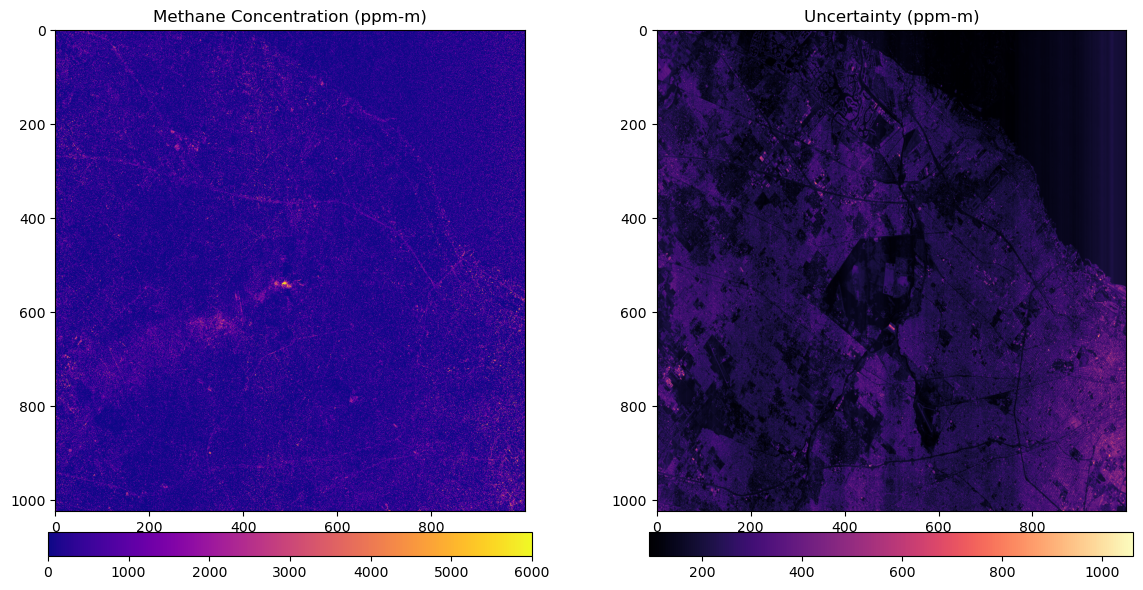

In [56]:

conc_arr, geotransform, projection, _ = plumes_analyzer.load_geotiff(str(CONCENTRATION_FILE))
unc_arr, _, _, _ = plumes_analyzer.load_geotiff(str(UNCERTAINTY_FILE))

reporter.log_block(
    'Input raster summary',
    [
        f'Concentration raster: {CONCENTRATION_FILE.name}',
        f'Uncertainty raster: {UNCERTAINTY_FILE.name}',
        f'Array shape: {conc_arr.shape}'
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

im1 = ax1.imshow(conc_arr, cmap='plasma', vmin=0, vmax=6000)
ax1.set_title('Methane Concentration (ppm-m)')
fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

im2 = ax2.imshow(unc_arr, cmap='magma')
ax2.set_title('Uncertainty (ppm-m)')
fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

plt.tight_layout()
reporter.log_figure('Scene-wide concentration and uncertainty', fig)
plt.show()


## 4. Background-Matched Noise Estimation

We repeat the PRISMA spectral background workflow: project the plume mask onto the instrument sampling grid, measure spectral distances on methane-free bands, select plume-free pixels with matching spectra, and derive $\sigma_{surf}$ for later propagation.


In [ ]:
SUMMARY_DIR = NOTEBOOK_ROOT / 'outputs' / 'uncertainty' / 'prisma_plume_background'
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

def _rasterize_vector(vector_path, rows, cols, geo_transform, projection):
    vector_ds = ogr.Open(str(vector_path))
    if vector_ds is None:
        raise RuntimeError(f'Failed to open vector file: {vector_path}')
    layer = vector_ds.GetLayer()
    mask_ds = gdal.GetDriverByName('MEM').Create('', cols, rows, 1, gdal.GDT_Byte)
    mask_ds.SetGeoTransform(geo_transform)
    mask_ds.SetProjection(projection)
    gdal.RasterizeLayer(mask_ds, [1], layer, burn_values=[1])
    mask_array = mask_ds.ReadAsArray().astype(bool)
    mask_ds = None
    layer = None
    vector_ds = None
    return mask_array

def _slugify(value):
    return ''.join(ch.lower() if ch.isalnum() else '_' for ch in str(value)).strip('_')

def _mask_array(data, mask):
    masked = np.full(data.shape, np.nan, dtype=float)
    masked[mask] = data[mask]
    return masked

def _auto_plume_mask(concentration, finite_mask, percentiles, min_pixels):
    if not np.any(finite_mask):
        return None, {}
    values = concentration[finite_mask]
    if values.size == 0:
        return None, {}
    for perc in percentiles:
        threshold = float(np.nanpercentile(values, perc))
        candidate = (concentration >= threshold) & finite_mask
        if candidate.sum() >= min_pixels:
            return candidate, {'source': f'auto_percentile_{perc}', 'threshold': threshold}
    return None, {}

def _prepare_prisma_l1(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f'PRISMA asset not found: {path}')
    if path.suffix.lower() == '.zip':
        temp_dir = tempfile.TemporaryDirectory()
        extracted = prisma_utils.extract_he5_from_zip(str(path), temp_dir.name)
        if not extracted:
            temp_dir.cleanup()
            raise FileNotFoundError(f'No .he5 file found inside {path}')
        return extracted, temp_dir
    return str(path), None

def _load_spectral_cube(assets):
    l1_path, temp_dir = _prepare_prisma_l1(Path(assets['l1']))
    try:
        cube, cw_matrix, _, _, _, _, lat_vnir, lon_vnir, lat_swir, lon_swir = prisma_utils.prisma_read(l1_path)
    finally:
        if temp_dir is not None:
            temp_dir.cleanup()
    cube = cube.astype(np.float32)
    wavelengths = np.mean(cw_matrix, axis=0).astype(np.float32)
    lat_grid = np.rot90(lat_swir, k=-1).astype(np.float32)
    lon_grid = np.rot90(lon_swir, k=-1).astype(np.float32)
    finite_mask = np.all(np.isfinite(cube), axis=2)
    return {
        'cube': cube,
        'wavelengths': wavelengths,
        'lat': lat_grid,
        'lon': lon_grid,
        'finite_mask': finite_mask,
    }

def _band_mask(wavelengths, windows, guard_nm):
    wav = np.asarray(wavelengths, dtype=float).ravel()
    mask = np.ones_like(wav, dtype=bool)
    for lo, hi in windows:
        lower = lo - guard_nm
        upper = hi + guard_nm
        mask &= ~((wav >= lower) & (wav <= upper))
    return mask

def _spectral_distance(cube, ref_mean, ref_std):
    standardized = (cube - ref_mean) / ref_std
    return np.sqrt(np.nanmean(standardized**2, axis=2))

def _select_background(distance_map, candidate_mask, percentiles, min_fraction, min_pixels, fallback_percentile=70.0):
    candidate_values = distance_map[candidate_mask]
    if candidate_values.size == 0:
        return candidate_mask & False, None, None
    min_required = max(int(np.ceil(candidate_values.size * min_fraction)), int(min_pixels))
    for perc in percentiles:
        threshold = float(np.nanpercentile(candidate_values, perc))
        mask = (distance_map <= threshold) & candidate_mask
        if mask.sum() >= min_required:
            return mask, threshold, perc
    threshold = float(np.nanpercentile(candidate_values, fallback_percentile))
    mask = (distance_map <= threshold) & candidate_mask
    return mask, threshold, fallback_percentile

def _latlon_to_pixel(lat, lon, geo_transform):
    a, b, c, d, e, f = geo_transform
    denom = b * f - c * e
    if denom == 0:
        raise ValueError('Non-invertible geotransform encountered.')
    x = lon - a
    y = lat - d
    col = (f * x - c * y) / denom
    row = (-e * x + b * y) / denom
    return row, col

def _geo_mask_to_instrument(mask_geo, lat_grid, lon_grid, geo_transform):
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_idx = np.rint(rows).astype(int)
    cols_idx = np.rint(cols).astype(int)
    valid = (
        np.isfinite(rows_idx)
        & np.isfinite(cols_idx)
        & (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < mask_geo.shape[0])
        & (cols_idx < mask_geo.shape[1])
    )
    instrument_mask = np.zeros(lat_grid.shape, dtype=bool)
    instrument_mask[valid] = mask_geo[rows_idx[valid], cols_idx[valid]]
    return instrument_mask

def _instrument_mask_to_geo(mask_instr, lat_grid, lon_grid, geo_transform, geo_shape):
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    mask_vals = mask_instr.ravel()
    valid = mask_vals & np.isfinite(rows_flat) & np.isfinite(cols_flat)
    rows_idx = np.rint(rows_flat[valid]).astype(int)
    cols_idx = np.rint(cols_flat[valid]).astype(int)
    in_bounds = (
        (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < geo_shape[0])
        & (cols_idx < geo_shape[1])
    )
    rows_idx = rows_idx[in_bounds]
    cols_idx = cols_idx[in_bounds]
    counts = np.zeros(geo_shape, dtype=np.int32)
    np.add.at(counts, (rows_idx, cols_idx), 1)
    return counts > 0

def _instrument_scalar_to_geo(values, lat_grid, lon_grid, geo_transform, geo_shape):
    rows, cols = _latlon_to_pixel(lat_grid, lon_grid, geo_transform)
    rows_flat = rows.ravel()
    cols_flat = cols.ravel()
    vals = values.ravel()
    valid = np.isfinite(vals) & np.isfinite(rows_flat) & np.isfinite(cols_flat)
    rows_idx = np.rint(rows_flat[valid]).astype(int)
    cols_idx = np.rint(cols_flat[valid]).astype(int)
    in_bounds = (
        (rows_idx >= 0)
        & (cols_idx >= 0)
        & (rows_idx < geo_shape[0])
        & (cols_idx < geo_shape[1])
    )
    rows_idx = rows_idx[in_bounds]
    cols_idx = cols_idx[in_bounds]
    vals = vals[valid][in_bounds]
    sum_arr = np.zeros(geo_shape, dtype=np.float64)
    count_arr = np.zeros(geo_shape, dtype=np.int32)
    np.add.at(sum_arr, (rows_idx, cols_idx), vals)
    np.add.at(count_arr, (rows_idx, cols_idx), 1)
    out = np.full(geo_shape, np.nan, dtype=np.float32)
    valid_cells = count_arr > 0
    out[valid_cells] = (sum_arr[valid_cells] / count_arr[valid_cells]).astype(np.float32)
    return out

def _derive_matched_background(scene_config, plume_mask_geo, base_mask_geo, geo_transform, spectral_context):
    if not spectral_context:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'missing_assets', 'distance_map': None}
    cube = spectral_context['cube']
    lat_grid = spectral_context['lat']
    lon_grid = spectral_context['lon']
    wavelengths = spectral_context['wavelengths']

    plume_mask_instr = _geo_mask_to_instrument(plume_mask_geo, lat_grid, lon_grid, geo_transform) if plume_mask_geo is not None else None
    base_mask_instr = _geo_mask_to_instrument(base_mask_geo, lat_grid, lon_grid, geo_transform)

    windows = scene_config.get('methane_windows_nm', [(1625.0, 1695.0), (2100.0, 2450.0)])
    guard = scene_config.get('methane_guard_nm', 8.0)
    usable_bands = _band_mask(wavelengths, windows, guard)
    if not np.any(usable_bands):
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_usable_bands', 'distance_map': None}

    cube_subset = cube[:, :, usable_bands]
    finite_subset = np.all(np.isfinite(cube_subset), axis=2)
    if plume_mask_instr is None:
        ref_mask_instr = base_mask_instr & finite_subset
    else:
        ref_mask_instr = plume_mask_instr & finite_subset
    plume_reference = cube_subset[ref_mask_instr]
    if plume_reference.size == 0:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_reference_pixels', 'distance_map': None}

    ref_mean = np.nanmedian(plume_reference, axis=0)
    ref_std = np.nanstd(plume_reference, axis=0, ddof=1)
    ref_std = np.where(ref_std > 0, ref_std, 1.0)

    candidate_mask = base_mask_instr & finite_subset
    if not np.any(candidate_mask):
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'no_candidate_pixels', 'distance_map': None}

    distance_map = _spectral_distance(cube_subset, ref_mean, ref_std)
    matched_mask, threshold, percentile = _select_background(
        distance_map,
        candidate_mask,
        scene_config.get('spectral_match_percentiles', (10, 15, 20, 30, 40, 50)),
        scene_config.get('min_background_fraction', 0.01),
        scene_config.get('min_background_pixels', 750),
    )
    if matched_mask.sum() == 0:
        return base_mask_geo, {'strategy': 'plume_free', 'reason': 'selection_empty', 'distance_map': None}

    background_mask_geo = _instrument_mask_to_geo(matched_mask, lat_grid, lon_grid, geo_transform, base_mask_geo.shape)
    distance_map_geo = _instrument_scalar_to_geo(distance_map, lat_grid, lon_grid, geo_transform, base_mask_geo.shape)

    info = {
        'strategy': 'spectrally_matched',
        'percentile': percentile,
        'threshold': threshold,
        'reference_pixels': int(plume_reference.shape[0]),
        'usable_bands': int(cube_subset.shape[2]),
        'instrument_background_pixels': int(matched_mask.sum()),
        'distance_map': distance_map_geo,
    }
    return background_mask_geo, info

SIGMA_RMN_AGGREGATION = CASE_CONFIG.get('sigma_rmn_aggregation', 'mean')
METHANE_WINDOWS_NM = CASE_CONFIG.get('methane_windows_nm', [(1625.0, 1695.0), (2100.0, 2450.0)])
METHANE_GUARD_NM = CASE_CONFIG.get('methane_guard_nm', 8.0)
SPECTRAL_MATCH_PERCENTILES = CASE_CONFIG.get('spectral_match_percentiles', (10, 15, 20, 30, 40, 50))
AUTO_PLUME_PERCENTILES = CASE_CONFIG.get('auto_plume_percentiles', (99.5, 99.0, 98.0, 97.0, 95.0))
MIN_BACKGROUND_PIXELS = CASE_CONFIG.get('min_background_pixels', 750)
MIN_BACKGROUND_FRACTION = CASE_CONFIG.get('min_background_fraction', 0.01)
AUTO_PLUME_MIN_PIXELS = CASE_CONFIG.get('auto_plume_min_pixels', 200)

concentration = conc_arr.astype(np.float32)
uncertainty = unc_arr.astype(np.float32)
geo_transform = geotransform
projection = projection

plume_mask = None
plume_mask_source = 'none'
plume_mask_meta = {}
if SHAPEFILE_PATH and SHAPEFILE_PATH.exists():
    print(f"Using plume mask: {SHAPEFILE_PATH}")
    plume_mask = _rasterize_vector(SHAPEFILE_PATH, concentration.shape[0], concentration.shape[1], geo_transform, projection)
    plume_mask_source = 'vector'
else:
    print('No plume shapefile found; attempting automatic plume mask from concentration percentiles.')

finite_only = np.isfinite(concentration) & np.isfinite(uncertainty)
if plume_mask is None:
    auto_mask, meta = _auto_plume_mask(concentration, finite_only, AUTO_PLUME_PERCENTILES, AUTO_PLUME_MIN_PIXELS)
    if auto_mask is not None:
        plume_mask = auto_mask
        plume_mask_source = meta.get('source', 'auto_percentile')
        plume_mask_meta = meta
        thr = meta.get('threshold')
        if thr is not None:
            print(f"Auto-derived plume mask ({plume_mask_source}) with threshold {thr:.2f} ppm·m.")
        else:
            print(f'Auto-derived plume mask using {plume_mask_source} percentiles.')
    else:
        print('Automatic plume mask derivation failed; treating entire scene as plume-free background.')

plume_free_mask = ~plume_mask if plume_mask is not None else np.ones_like(concentration, dtype=bool)
plume_free_finite_mask = plume_free_mask & finite_only
if not np.any(plume_free_finite_mask):
    raise ValueError('No valid plume-free pixels available for statistics.')

spectral_context = None
if CASE_CONFIG.get('spectral_assets'):
    try:
        spectral_context = _load_spectral_cube(CASE_CONFIG['spectral_assets'])
    except Exception as exc:
        print(f'Unable to load spectral assets: {exc}')

background_mask, background_info = _derive_matched_background(
    CASE_CONFIG,
    plume_mask,
    plume_free_finite_mask,
    geo_transform,
    spectral_context,
)
if background_mask is None or not np.any(background_mask):
    background_mask = plume_free_finite_mask
    background_info = background_info or {}
    background_info.setdefault('strategy', 'plume_free_fallback')

strategy = background_info.get('strategy', 'plume_free')
print(f'Background selection strategy: {strategy}')
if strategy == 'spectrally_matched':
    desc = f"percentile={background_info.get('percentile')}"
    thr = background_info.get('threshold')
    if thr is not None:
        desc += f", threshold={thr:.3f}"
    print(f"Matched {int(background_mask.sum())} pixels ({desc}).")
else:
    print('Falling back to plume-free finite pixels for clutter estimation.')

distance_map = background_info.get('distance_map')
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
axes[0].imshow(plume_mask if plume_mask is not None else np.zeros_like(concentration, dtype=bool), cmap='gray')
axes[0].set_title(f'Plume mask ({plume_mask_source})')
axes[1].imshow(plume_free_finite_mask, cmap='gray')
axes[1].set_title('Plume-free, finite pixels')
if distance_map is not None:
    im = axes[2].imshow(np.ma.masked_invalid(distance_map), cmap='magma')
    axes[2].set_title('Spectral distance (z-score)')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
else:
    axes[2].imshow(np.zeros_like(concentration, dtype=float), cmap='gray')
    axes[2].set_title('Spectral distance unavailable')
axes[3].imshow(background_mask, cmap='gray')
axes[3].set_title('Background pixels used')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

if not np.any(background_mask):
    raise ValueError('No background pixels available after selection.')

delta_x = concentration[background_mask]
sigma_tot = float(np.nanstd(delta_x, ddof=1))

sigma_rmn_vals = uncertainty[background_mask]
agg = SIGMA_RMN_AGGREGATION.lower().strip()
if agg == 'median':
    sigma_rmn_stat = float(np.nanmedian(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmedian(sigma_rmn_vals ** 2))
else:
    sigma_rmn_stat = float(np.nanmean(sigma_rmn_vals))
    sigma_rmn_sq = float(np.nanmean(sigma_rmn_vals ** 2))

sigma_surf = float(np.sqrt(max(0.0, sigma_tot ** 2 - sigma_rmn_sq)))

if plume_mask is not None:
    plume_pixels_mask = plume_mask & finite_only
else:
    print('Plume mask missing: plume-level summaries will cover the whole scene.')
    plume_pixels_mask = finite_only

plume_pixel_count = int(plume_pixels_mask.sum())
if plume_pixel_count == 0:
    raise ValueError('No plume pixels available for plume-level uncertainty mapping.')

plume_sigma_rmn = _mask_array(uncertainty, plume_pixels_mask)
plume_sigma_total = _mask_array(np.sqrt(np.maximum(0.0, uncertainty ** 2 + sigma_surf ** 2)), plume_pixels_mask)

plume_sigma_rmn_mean = float(np.nanmean(plume_sigma_rmn[plume_pixels_mask]))
plume_sigma_total_mean = float(np.nanmean(plume_sigma_total[plume_pixels_mask]))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
im0 = axes[0].imshow(concentration, cmap='plasma', vmin=0, vmax=8000)
axes[0].set_title('CH$_4$ enhancement (ppm·m)')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
im1 = axes[1].imshow(plume_sigma_rmn, cmap='plasma')
axes[1].set_title('σ$_{RMN}$ over plumes (ppm·m)')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
im2 = axes[2].imshow(plume_sigma_total, cmap='plasma')
axes[2].set_title('Total plume σ (ppm·m)')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
for ax in axes:
    ax.axis('off')
plt.suptitle('Plume-level uncertainty products', fontsize=14)
plt.tight_layout()
plt.show()

metrics = {
    'scene': CASE_CONFIG.get('scene_name', SELECTED_CASE),
    'concentration_path': str(CONCENTRATION_FILE),
    'uncertainty_path': str(UNCERTAINTY_FILE),
    'plume_mask_path': str(SHAPEFILE_PATH) if SHAPEFILE_PATH else None,
    'plume_mask_source': plume_mask_source,
    'auto_plume_threshold': plume_mask_meta.get('threshold'),
    'valid_pixels': int(plume_free_finite_mask.sum()),
    'background_pixels': int(background_mask.sum()),
    'instrument_background_pixels': background_info.get('instrument_background_pixels'),
    'background_strategy': background_info.get('strategy'),
    'spectral_percentile': background_info.get('percentile'),
    'spectral_distance_threshold': background_info.get('threshold'),
    'spectral_reference_pixels': background_info.get('reference_pixels'),
    'spectral_usable_bands': background_info.get('usable_bands'),
    'methane_windows_nm': METHANE_WINDOWS_NM,
    'methane_guard_nm': METHANE_GUARD_NM,
    'plume_pixels': plume_pixel_count,
    'sigma_tot': sigma_tot,
    'sigma_rmn_sq': sigma_rmn_sq,
    'sigma_rmn_value': sigma_rmn_stat,
    'sigma_surf': sigma_surf,
    'sigma_rmn_aggregation': agg,
    'mean_plume_sigma_rmn': plume_sigma_rmn_mean,
    'mean_plume_sigma_total': plume_sigma_total_mean,
}
metrics_path = SUMMARY_DIR / f"{_slugify(CASE_CONFIG.get('scene_name', SELECTED_CASE))}_noise_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print('Scene noise metrics:')
for key, value in metrics.items():
    print(f'  {key}: {value}')
print(f'Saved metrics to {metrics_path}')

SIGMA_SURF = sigma_surf
SIGMA_SURF_PPB = SIGMA_SURF * 0.125
reporter.log_block(
    'Background-matched uncertainty',
    [
        f"Strategy: {strategy}",
        f"σ_tot (ppm·m): {sigma_tot:.4f}",
        f"σ_RMN (ppm·m): {sigma_rmn_stat:.4f}",
        f"σ_surf (ppm·m): {SIGMA_SURF:.4f}",
        f"σ_surf (ppb): {SIGMA_SURF_PPB:.4f}",
        f"Background pixels: {int(background_mask.sum())}"
    ]
)


## 4. Load the Segmented Plume Polygons

The matched filter pipeline may produce multiple plume polygons. We load the shapefile, project it to a local UTM CRS for area measurements, and prepare a record for each plume that will be analyzed in the following steps.

Plume polygon summary
Loaded 1 plume polygon(s) from Buenos_Aires_plume_hygas.shp
Shapefile CRS: EPSG:4326
Raster CRS for clipping: EPSG:4326
Projected CRS for area calculations: EPSG:32721



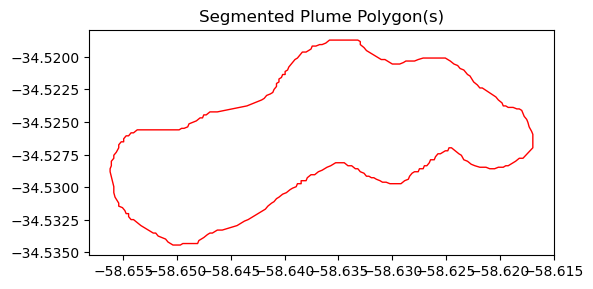

In [57]:
if not SHAPEFILE_PATH.exists():
    raise FileNotFoundError(f'Plume shapefile not found: {SHAPEFILE_PATH}')

gdf = gpd.read_file(SHAPEFILE_PATH)
_, _, raster_wkt, _ = plumes_analyzer.load_geotiff(str(CONCENTRATION_FILE))
raster_crs = CRS.from_wkt(raster_wkt)
gdf_raster = gdf.to_crs(raster_crs)
projected_gdf, projected_epsg = plumes_analyzer.project_gdf_to_local_utm(gdf)

plume_records = []
for (idx, row), (_, proj_row), (_, raster_row) in zip(gdf.iterrows(), projected_gdf.iterrows(), gdf_raster.iterrows()):
    plume_records.append({
        'plume_id': idx,
        'geom': row.geometry,
        'geom_raster': raster_row.geometry,
        'projected_geom': proj_row.geometry
    })

summary_lines = [
    f'Loaded {len(plume_records)} plume polygon(s) from {SHAPEFILE_PATH.name}',
    f'Shapefile CRS: {gdf.crs}',
    f'Raster CRS for clipping: {raster_crs.to_string()}',
    f'Projected CRS for area calculations: EPSG:{projected_epsg}'
]
reporter.log_block('Plume polygon summary', summary_lines)

ax = gdf.plot(edgecolor='red', facecolor='none', figsize=(6, 6))
ax.set_title('Segmented Plume Polygon(s)')
fig = ax.get_figure()
reporter.log_figure('Segmented plume polygon(s)', fig)
plt.show()


## 5. Unit Conversion

The input data is in `ppm-m` (parts per million-meter), but the IME calculation requires `ppb` (parts per billion). We convert the concentration and uncertainty values from `ppm-m` to `ppb` once here, and these arrays serve as the starting point for every plume-specific calculation.


In [58]:

conc_clean = plumes_analyzer.discard_neg(conc_arr)
unc_clean = plumes_analyzer.discard_neg(unc_arr)

conc_ppb = plumes_analyzer.ppm_m_to_ppb(conc_clean)
unc_ppb = plumes_analyzer.ppm_m_to_ppb(unc_clean)

reporter.log_block(
    'PPB conversion overview',
    [
        f'Original max concentration: {np.max(conc_arr):.2f} ppm-m',
        f'Converted max concentration: {np.max(conc_ppb):.2f} ppb'
    ]
)


PPB conversion overview
Original max concentration: 9671.30 ppm-m
Converted max concentration: 1208.91 ppb



## 7. Clipping the Rasters for Each Plume

For each polygon in the plume mask we clip the concentration and uncertainty rasters, keeping only positive values. This yields one pair of maps per plume that we will use for statistics, IME, and flux estimates. The clipped uncertainty arrays now include both the detector noise and the background σ$_{surf}$ term derived earlier.


In [ ]:
plume_outputs = []
for record in plume_records:
    plume_id = record['plume_id']
    conc_out = OUTPUT_DIR / f'clipped_conc_plume_{plume_id}.tif'
    unc_out = OUTPUT_DIR / f'clipped_unc_plume_{plume_id}.tif'
    clip_geom = record['geom_raster']
    clipped_conc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(CONCENTRATION_FILE),
        clip_geom,
        str(conc_out)
    )
    clipped_conc_arr = plumes_analyzer.discard_neg(clipped_conc_arr)

    clipped_unc_arr = plumes_analyzer.clip_raster_to_polygon(
        str(UNCERTAINTY_FILE),
        clip_geom,
        str(unc_out)
    )
    clipped_unc_arr = plumes_analyzer.discard_neg(clipped_unc_arr)

    total_unc_arr = np.sqrt(np.maximum(0.0, clipped_unc_arr**2 + SIGMA_SURF**2))

    clipped_conc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_conc_arr)
    clipped_unc_ppb = plumes_analyzer.ppm_m_to_ppb(clipped_unc_arr)
    clipped_unc_total_ppb = plumes_analyzer.ppm_m_to_ppb(plumes_analyzer.discard_neg(total_unc_arr))
    plume_stats = plumes_analyzer.compute_plume_stats(clipped_conc_ppb)

    plume_outputs.append({
        'plume_id': plume_id,
        'geom': record['geom'],
        'geom_raster': clip_geom,
        'projected_geom': record['projected_geom'],
        'clipped_conc_ppb': clipped_conc_ppb,
        'clipped_unc_ppb': clipped_unc_ppb,
        'clipped_unc_total_ppb': clipped_unc_total_ppb,
        'plume_stats': plume_stats
    })

    positive_pixels = int(np.count_nonzero(clipped_conc_ppb))
    reporter.log_block(
        f'Plume {plume_id} clipped rasters',
        [
            f'Concentration raster saved to {conc_out.name}',
            f'Uncertainty raster saved to {unc_out.name}',
            f'Positive concentration pixels: {positive_pixels}',
            f'Background σ_surf added in quadrature: {SIGMA_SURF:.3f} ppm·m'
        ]
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    im1 = ax1.imshow(clipped_conc_ppb, cmap='plasma', vmin=0, vmax=500)
    ax1.set_title(f'Plume {plume_id}: Concentration (ppb)')
    fig.colorbar(im1, ax=ax1, orientation='horizontal', fraction=0.046, pad=0.04)

    im2 = ax2.imshow(clipped_unc_ppb, cmap='magma', vmin=0, vmax=40)
    ax2.set_title(f'Plume {plume_id}: Uncertainty (ppb)')
    fig.colorbar(im2, ax=ax2, orientation='horizontal', fraction=0.046, pad=0.04)

    plt.tight_layout()
    reporter.log_figure(f'Plume {plume_id} clipped rasters', fig)
    plt.show()


### Plume concentration statistics

We report descriptive statistics for each plume's positive ppb pixels.

In [60]:

for output in plume_outputs:
    stats = output['plume_stats']
    reporter.log_block(
        f"Plume {output['plume_id']} concentration statistics",
        [
            f"Positive plume pixels: {stats['pixel_count']}",
            f"Min concentration: {stats['min']:.2f} ppb",
            f"Max concentration: {stats['max']:.2f} ppb",
            f"Mean concentration: {stats['mean']:.2f} ppb",
            f"Median concentration: {stats['median']:.2f} ppb"
        ]
    )


Plume 0 concentration statistics
Positive plume pixels: 1899
Min concentration: 0.09 ppb
Max concentration: 1208.91 ppb
Mean concentration: 163.81 ppb
Median concentration: 135.43 ppb



## 7. Integrated Methane Enhancement (IME) Calculation

The Integrated Methane Enhancement (IME) represents the total mass of methane in a plume. For every plume we sum the concentration of all pixels within the clipped mask and multiply by a conversion factor. The formula is:

$$ IME (kg) = \sum_{i=1}^{N} (ppb_i) * k $$
where:
- $ppb_i$ is the methane concentration in ppb for pixel i.
- $N$ is the total number of pixels in the plume.
- $k$ is a conversion factor that depends on the pixel area (GSD), and the molar masses of methane and air.

The conversion factor $k$ is calculated as:

$$ k = (GSD^2) * (\frac{M_{CH4}}{M_{air}}) * 10000 * 10^{-9} $$
where:
- $GSD$ is the ground sample distance in meters.
- $M_{CH4}$ is the molar mass of methane (16.04 g/mol).
- $M_{air}$ is the molar mass of dry air (28.97 g/mol).


In [61]:
for output in plume_outputs:
    ime = plumes_analyzer.calculate_ime(output['clipped_conc_ppb'], CASE_CONFIG['gsd'])
    output['ime'] = ime
    reporter.log_block(
        f"Plume {output['plume_id']} IME",
        [
            f"Integrated Methane Enhancement (IME): {ime:.2f} kg (GSD: {CASE_CONFIG['gsd']} m)"
        ]
    )


Plume 0 IME
Integrated Methane Enhancement (IME): 1550.10 kg (GSD: 30 m)



## 9. IME Uncertainty Calculation

We propagate two components: the detector noise stored in the uncertainty raster and the spectrally matched background variance ($\sigma_{surf}$). Both terms are added in quadrature at the pixel level before converting to IME uncertainty.


In [ ]:
for output in plume_outputs:
    sigma_ime_instr = plumes_analyzer.calculate_sigma_ime(output['clipped_unc_ppb'], CASE_CONFIG['gsd'])
    sigma_ime_total = plumes_analyzer.calculate_sigma_ime(output['clipped_unc_total_ppb'], CASE_CONFIG['gsd'])
    output['sigma_ime_instr'] = sigma_ime_instr
    output['sigma_ime_total'] = sigma_ime_total
    output['sigma_ime'] = sigma_ime_total
    reporter.log_block(
        f"Plume {output['plume_id']} σ_IME",
        [
            f"Instrument-only IME uncertainty: {sigma_ime_instr:.2f} kg",
            f"IME uncertainty with background: {sigma_ime_total:.2f} kg"
        ]
    )


## 9. Wind Response and Flux Calculation

The methane flux (Q) is the rate at which methane is emitted. For each plume we use its IME, an effective wind speed ($U_{eff}$), and the length scale ($L$) computed from the plume area. The formula is:

$$ Q (t/h) = \frac{U_{eff} * IME * 3.6}{L} $$
where:
- $U_{eff}$ is the effective wind speed in m/s.
- $IME$ is the integrated methane enhancement in kg.
- $L$ is the length scale of the plume in meters, approximated as the square root of the plume area.
- The factor 3.6 converts from kg/s to t/h.

The effective wind speed $U_{eff}$ is calculated from the wind speed at 10 meters ($U_{10}$) using a sensor-specific linear relationship. Prior to computing each area, we project the plume polygon to a local UTM CRS so measurements are in square meters.



In [63]:

for output in plume_outputs:
    area = output['projected_geom'].area
    L = math.sqrt(area)
    u_eff, a, b = plumes_analyzer.compute_u_eff(U10, SENSOR_TYPE)
    q = plumes_analyzer.compute_flux(output['ime'], u_eff, L)
    output.update({'area': area, 'L': L, 'u_eff': u_eff, 'a': a, 'b': b, 'q': q})
    reporter.log_block(
        f"Plume {output['plume_id']} area and flux",
        [
            f"Area: {area:.2f} m^2 (Projected EPSG:{projected_epsg})",
            f"Length Scale (L): {L:.2f} m",
            f"Effective Wind Speed (U_eff): {u_eff:.2f} m/s",
            f"Methane Flux (Q): {q:.2f} t/h"
        ]
    )


Plume 0 area and flux
Area: 3177179.06 m^2 (Projected EPSG:32721)
Length Scale (L): 1782.46 m
Effective Wind Speed (U_eff): 3.17 m/s
Methane Flux (Q): 9.92 t/h



## 11. Flux Uncertainty Propagation

Flux uncertainty ($\sigma_Q$) combines the IME uncertainty (now including the background contribution) and the wind uncertainty. We also retain the instrument-only baseline for comparison:

$$ \sigma_Q = \sqrt{\sigma_{Q,IME}^2 + \sigma_{Q,wind}^2} $$
with
- $\sigma_{Q,IME} = Q * (rac{\sigma_{IME}}{IME})$
- $\sigma_{Q,wind} = Q * (rac{\sigma_{Ueff}}{U_{eff}})$, where $\sigma_{Ueff} = |a| * \sigma_{U10}$


In [ ]:
for output in plume_outputs:
    sigma_q, sigma_q_ime, sigma_q_wind = plumes_analyzer.propagate_flux_uncertainty(
        output['q'],
        output['ime'],
        output['sigma_ime_total'],
        U10,
        SIGMA_U10,
        output['u_eff'],
        output['a']
    )
    sigma_q_instr, sigma_q_ime_instr, _ = plumes_analyzer.propagate_flux_uncertainty(
        output['q'],
        output['ime'],
        output['sigma_ime_instr'],
        U10,
        SIGMA_U10,
        output['u_eff'],
        output['a']
    )
    output.update({
        'sigma_q': sigma_q,
        'sigma_q_instr': sigma_q_instr,
        'sigma_q_ime_total': sigma_q_ime,
        'sigma_q_ime_instr': sigma_q_ime_instr,
        'sigma_q_wind': sigma_q_wind
    })
    reporter.log_block(
        f"Plume {output['plume_id']} flux uncertainty",
        [
            f"Total Flux Uncertainty (σ_Q, with background): ±{sigma_q:.2f} t/h",
            f"Flux Uncertainty using instrument σ only: ±{sigma_q_instr:.2f} t/h",
            f"Flux Uncertainty from IME (background-aware): {sigma_q_ime:.2f} t/h",
            f"Flux Uncertainty from Wind: {sigma_q_wind:.2f} t/h"
        ]
    )


## 12. Summary of Results

We summarize the per-plume metrics (IME, flux, uncertainties, and ppb statistics) so every plume in the shapefile is reported separately. Both the instrument-only and background-aware uncertainties are reported for traceability.


In [ ]:
for output in plume_outputs:
    stats = output['plume_stats']
    reporter.log_block(
        f"Plume {output['plume_id']} summary",
        [
            f"Plume Area: {output['area']:.2f} m^2",
            f"Plume Length Scale (L): {output['L']:.2f} m",
            f"Wind Speed (U10): {U10:.2f} ± {SIGMA_U10:.2f} m/s",
            f"Effective Wind Speed (U_eff): {output['u_eff']:.2f} m/s",
            f"Integrated Methane Enhancement (IME): {output['ime']:.2f} kg",
            f"σ_IME (instrument): ±{output['sigma_ime_instr']:.2f} kg",
            f"σ_IME (with background): ±{output['sigma_ime_total']:.2f} kg",
            f"Methane Flux (Q): {output['q']:.2f} ± {output['sigma_q']:.2f} t/h",
            f"Flux σ using instrument baseline: ±{output['sigma_q_instr']:.2f} t/h",
            f"Flux Uncertainty from IME: {output['sigma_q_ime_total']:.2f} t/h",
            f"Flux Uncertainty from Wind: {output['sigma_q_wind']:.2f} t/h",
            f"Positive Pixels: {stats['pixel_count']}",
            f"Min/Max (ppb): {stats['min']:.2f} / {stats['max']:.2f}",
            f"Mean/Median (ppb): {stats['mean']:.2f} / {stats['median']:.2f}"
        ]
    )


In [66]:

reporter.save()


Run report saved to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/plume_analysis_walkthrough/BuenosAires_20240112/plume_analysis_run_report.md
